In [3]:
# Imports and Setup
import warnings; warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# For interactive scatter plots
import plotly.express as px

from utils import (
    aggregate_hidden_states,
    roc_auc_for_group,
    make_bar_plot,
    make_heatmap,
    incremental_training_curve,
    cosine_similarity_matrix,
    pca_scatter_3d,
    perform_k_means_with_labels,
    plot_clusters_3d,
    train_logistic_regression_per_cluster,
    plot_coefficient_similarity,
    calculate_roc_auc,
)

In [4]:
SAMPLE_SIZE = 500

# Prepare DataFrame: deduplicate and group sample per source/label
cls_df = pd.read_parquet("data/truth_train_cls_dataset.parquet")
cls_df["source"] = cls_df.source.apply(lambda x: x.split("_")[0] if (("train" in x) or ("dev" in x) or ("test" in x)) else x).reset_index(drop=True)
cls_df = (
    cls_df.drop_duplicates(subset=["Question", "Answer"])
    .groupby(["source", "label"])
    .apply(lambda gp: gp.sample(n=SAMPLE_SIZE, random_state=0) if len(gp) > SAMPLE_SIZE else gp)
    .reset_index(drop=True)
)

all_sources = sorted(cls_df.source.unique())
cls_df.groupby("source")["label"].value_counts()

source          label
AnswerableMath  False    500
                True     500
logic_701       False    477
                True     454
mnli            False    500
                True     500
movie           False    500
                True     500
nq_wc_dataset   False    500
                True     318
triviaqa        False    500
                True     500
winobias        False    500
                True     500
winogrande      False    500
                True     500
Name: count, dtype: int64

Groupwise train/test:   0%|          | 0/8 [00:00<?, ?it/s]

Train-all, test-each:   0%|          | 0/8 [00:00<?, ?it/s]

Leave-one-out:   0%|          | 0/8 [00:00<?, ?it/s]

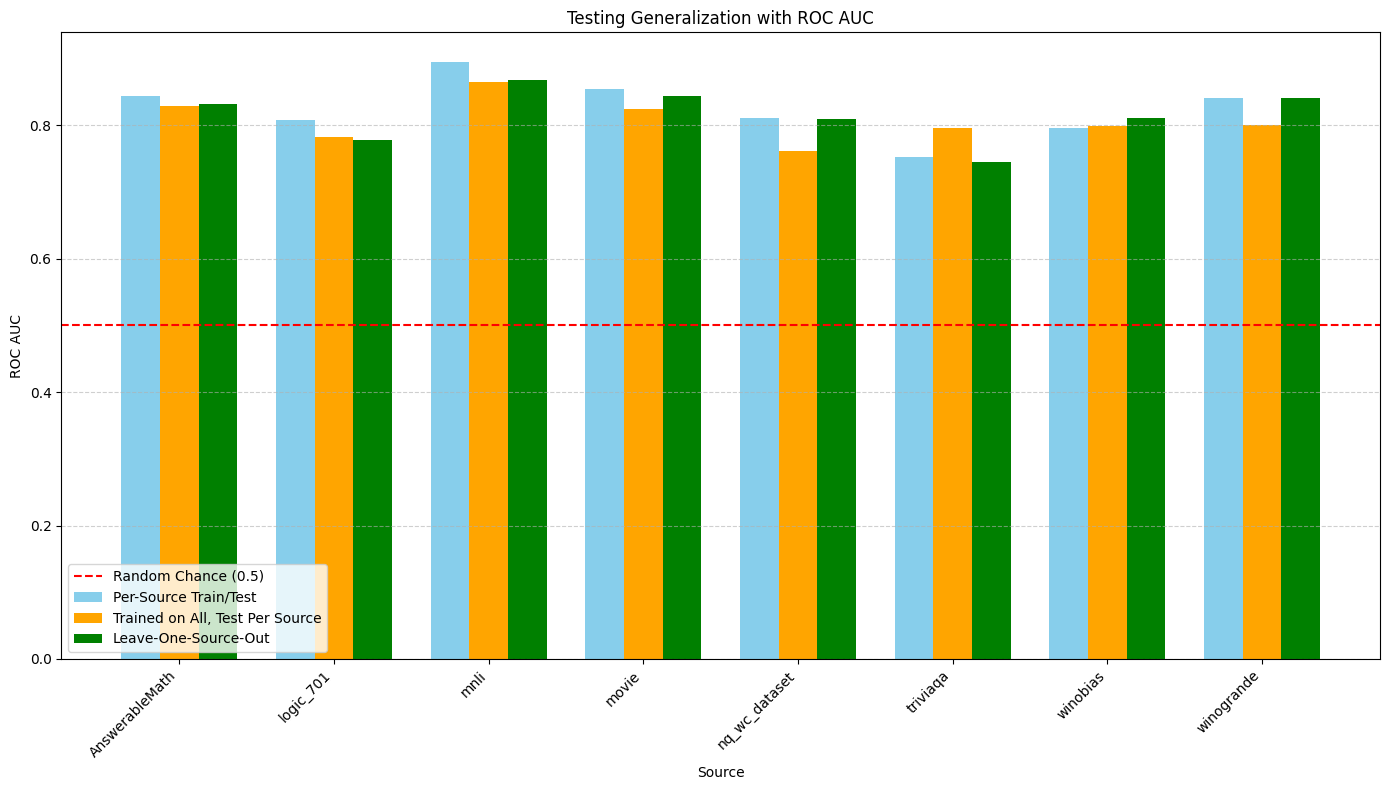

In [9]:
graph1_scores = roc_auc_for_group(cls_df, all_sources, mode="separate")
graph2_scores = roc_auc_for_group(cls_df, all_sources, mode="all_vs_each")
graph3_scores = roc_auc_for_group(cls_df, all_sources, mode="leave_one_out")

make_bar_plot(graph1_scores, graph2_scores, graph3_scores, all_sources)

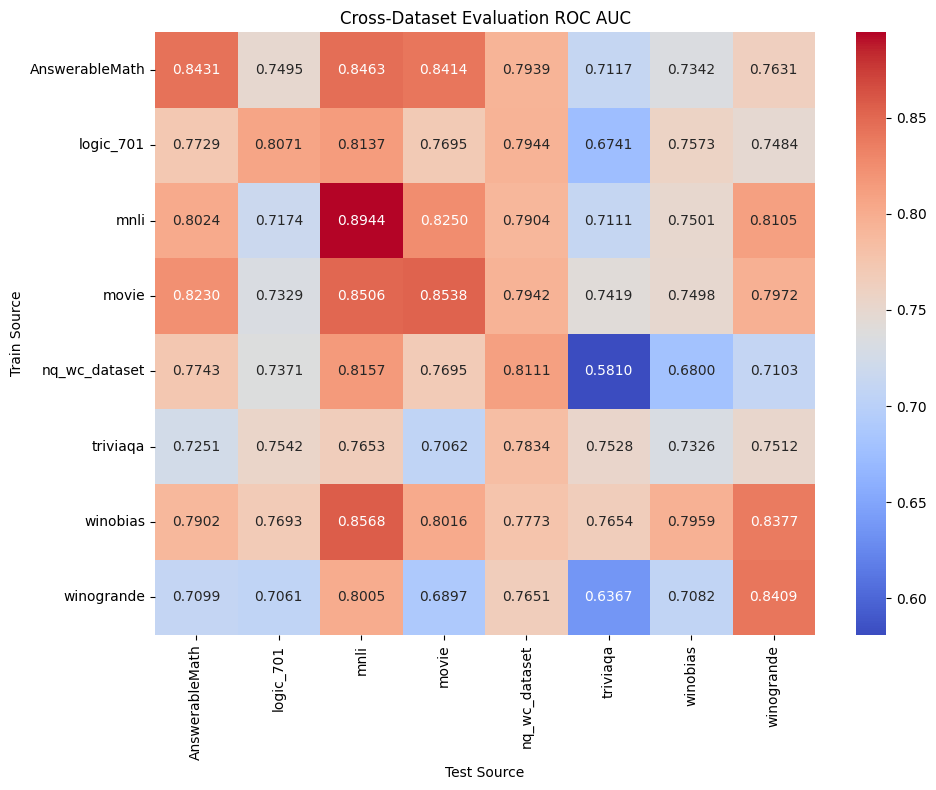

In [10]:
table, models = make_heatmap(cls_df, all_sources, aggregate_hidden_states)

Incremental transfer:   0%|          | 0/10 [00:00<?, ?it/s]

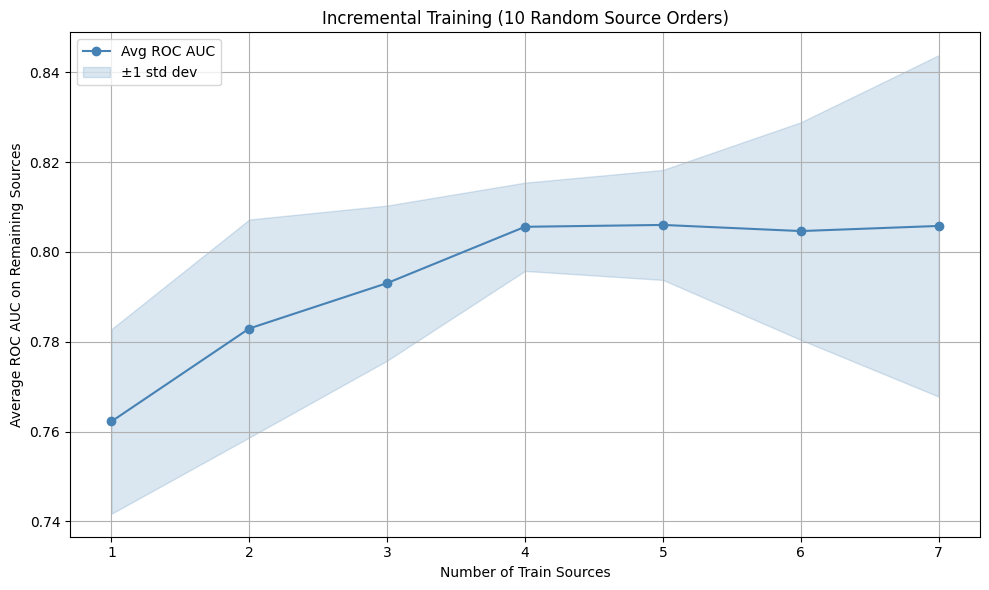

In [5]:
incremental_training_curve(cls_df, all_sources, aggregate_hidden_states, n_runs=10)

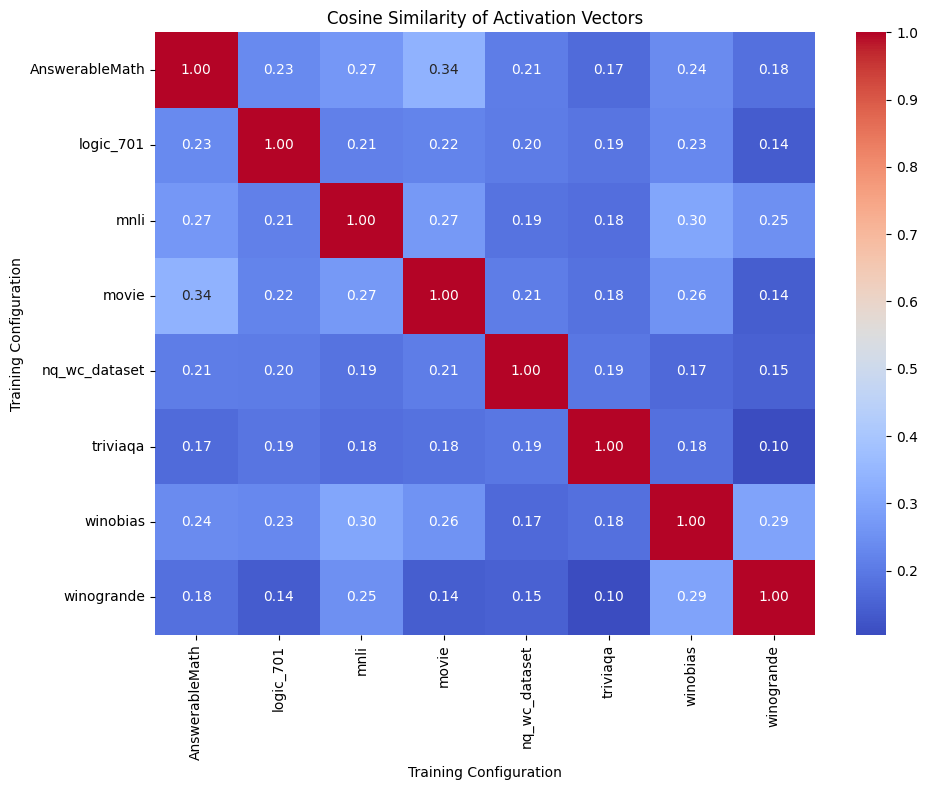

In [12]:
cosine_similarity_matrix(models)

In [13]:
# Prepare train/test as before
train_df = cls_df.sample(frac=1.0, random_state=0).groupby(["source", "label"]).apply(lambda gp: gp.iloc[:int(len(gp) * 0.8)]).reset_index(drop=True)
test_df = cls_df.sample(frac=1.0, random_state=0).groupby(["source", "label"]).apply(lambda gp: gp.iloc[int(len(gp) * 0.8):]).reset_index(drop=True)

X_train = np.stack([aggregate_hidden_states(hs) for hs in train_df["hidden_states"]])
y_train = train_df["label"].apply(lambda x: 1 if x.lower() == "true" else 0).values

X_test = np.stack([aggregate_hidden_states(hs) for hs in test_df["hidden_states"]])
y_test = test_df["label"].apply(lambda x: 1 if x.lower() == "true" else 0).values

pca_scatter_3d(X_train, y_train)

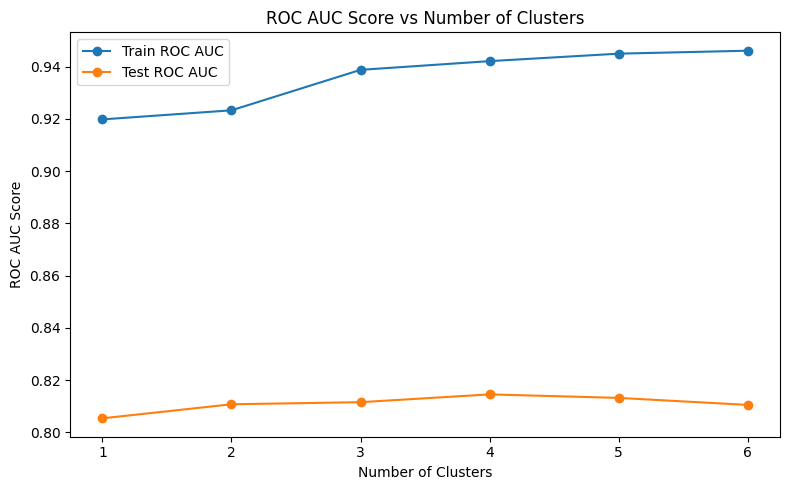

In [14]:
from collections import defaultdict

data = defaultdict(list)
max_clusters = 6

for num_clusters in range(1, max_clusters + 1):
    clusters, cluster_labels, clustering, _ = perform_k_means_with_labels(X_train, y_train, num_clusters)
    labels = clustering.predict(X_train)
    # plot_clusters_3d(X_train, labels)  # optional: 3D plot of clusters

    models_cluster = train_logistic_regression_per_cluster(clusters, cluster_labels)
    # plot_coefficient_similarity(models_cluster) # optional

    roc_auc_train = calculate_roc_auc(models_cluster, clustering, X_train, y_train)
    roc_auc_test = calculate_roc_auc(models_cluster, clustering, X_test, y_test)

    data["num_clusters"].append(num_clusters)
    data["roc_auc_train"].append(roc_auc_train)
    data["roc_auc_test"].append(roc_auc_test)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(data["num_clusters"], data["roc_auc_train"], label="Train ROC AUC", marker='o')
plt.plot(data["num_clusters"], data["roc_auc_test"], label="Test ROC AUC", marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("ROC AUC Score")
plt.title("ROC AUC Score vs Number of Clusters")
plt.legend()
plt.tight_layout()
plt.show()